In [10]:
adict = {}
bool(adict)

False

In [5]:
import sqlite3
from sqlite3 import Error
import re
import pandas as pd
import json
from indigo.indigo import *
#import matplotlib.pyplot as plt
#import numpy as np
import openbabel #must use python 3.6
import pybel
import webScrapeNPASSnCS
from selenium import webdriver
#%matplotlib inline

In [18]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect('file:{}?mode=rwc'.format(db_file),uri=True) #Read, Write & Create mode, so connecting to a non-existing database will cause it to be created
        print('sqlite3 version: '+sqlite3.version+'\n==============\n')
        return conn
    except Exception as e:
        print(e)

def create_table(conn,tableName):
    c = conn.cursor()
    exec_1 = 'CREATE TABLE IF NOT EXISTS '
    exec_2 = ''' (ChemSpider_ID INTEGER PRIMARY KEY, InChI_string TEXT, Std_InChI TEXT, 
                 Molecular_Formula TEXT, Average_Mass REAL, SMILES TEXT, Common_Name TEXT, Systematic_Name TEXT,
                 logP REAL,H_Bond_Donors INTEGER,H_Bond_Acceptors INTEGER,Num_Rota_Bonds INTEGER,Lipinski_Rule_5 INTEGER,
                 Polar_Surface_Area INTEGER,Enthalpy_Vap TEXT,Density TEXT,Boiling_Point TEXT,is_NP TEXT,
                 Arom_rings INTEGER,Num_Nitrogens INTEGER,Num_Oxygens INTEGER,SSSR INTEGER,Stereocenters INTEGER,Veber_Violations INTEGER)'''
    c.execute(exec_1 + tableName + exec_2)
    return c.lastrowid
#PSA is text because attached is the unit, angstrom which is text

def data_entry(conn,listOfProps,tbl,n,k):
    exec_1 = '''INSERT INTO  '''
    exec_2 = ''' (ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,
             SMILES,Common_Name,Systematic_Name,logP,H_Bond_Donors,H_Bond_Acceptors,Num_Rota_Bonds, 
             Lipinski_Rule_5,Polar_Surface_Area,Enthalpy_Vap,Density,Boiling_Point,is_NP) 
             VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)'''
    c = conn.cursor()
    c.execute(exec_1 + tbl + exec_2,listOfProps)
    print('({}) {} -> Saved to SQL Table'.format(n,k))
    #n is counter, k is key from CSDict keys
    
def Data_entry(conn,listOfProps,tblname,key):
    exec_1 = '''INSERT INTO  '''
    exec_2 = ''' (ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,
         SMILES,Common_Name,Systematic_Name,logP,H_Bond_Donors,H_Bond_Acceptors,Num_Rota_Bonds, 
         Lipinski_Rule_5,Polar_Surface_Area,Enthalpy_Vap,Density,Boiling_Point,is_NP,
         Arom_rings,Num_Nitrogens,Num_Oxygens,SSSR,Stereocenters,Veber_Violations) 
         VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)'''
    c = conn.cursor()
    c.executemany(exec_1 + tblname + exec_2,[listOfProps])
    print('ChemID:{} -> Added parametric entries to {}'.format(key,tblname))
    
def update_name(conn,tblname, nmID):
    exec_1 = 'UPDATE '
    exec_2 = ' SET Common_Name = ? WHERE ChemSpider_ID = ? '''
    c = conn.cursor()
    c.execute(exec_1 + tblname + exec_2,nmID) #list of names (new,CSID)
    conn.commit()
    print('Common Name for CS_ID: {} was changed to "{}"'.format(nmID[1],nmID[0]))
def update_data(conn, listOfProps,tbl,k):
    exec_1 = 'UPDATE '
    exec_2 = ''' SET InChI_string = ?,Std_InChI = ?,Molecular_Formula = ?,Average_Mass =?,
              SMILES=?, Common_Name=?, Systematic_Name=?, logP=?, H_Bond_Donors=?, H_Bond_Acceptors=?, Num_Rota_Bonds=?, 
              Lipinski_Rule_5=?, Polar_Surface_Area=?, Enthalpy_Vap=?, Density=?,Boiling_Point=?,is_NP=?,
              Arom_rings=?,Num_Nitrogens=?,Num_Oxygens=?,SSSR=?,Stereocenters=?,Veber_Violations=?
              WHERE ChemSpider_ID = '''
    c = conn.cursor()
    c.executemany(exec_1 + tbl + exec_2 + k, [listOfProps])
    conn.commit()
    print('{} -> Updated `{}` Table'.format(k,tbl))
def delete_entry(conn,tblname,queryArgs):
    sql1 = 'DELETE FROM '
    sql2 = ' WHERE '
    c= conn.cursor()
    c.execute(sql1 + tblname + sql2 +queryArgs)
    conn.commit()
def delete_all_entries(conn):
    sql = '''DELETE FROM CStable'''
    c = conn.cursor()
    c.execute(sql)
    conn.commit()
def drop_table(conn,tblname):
    sql1 = 'DROP TABLE '
    sql2 = '{}'.format(tblname)
    c = conn.cursor()
    c.execute(sql1+sql2)
    conn.commit()  
def get_sqlTable(conn):
    with conn:
        c = conn.cursor()
        c.execute("SELECT * FROM CStable")
        print(c.fetchall())
        
def unlock_db(db_filename):
    connection = create_connection(db_filename)
    connection.commit()
    connection.interrupt()
    connection.close()
    print('Connection closed')
    
def loopupdate(outerDict,n,k):
    loop =True
    while loop:
        updatentries = input('Do you want to update the TABLE entries for {}? (Y/N)'.format(k))
        if updatentries.lower() == 'y':
            try:
                update_data(conn,(outerDict[k]['InChI string'],outerDict[k]['Std InChI'],
                            outerDict[k]['Molecular Formula'],outerDict[k]['Average Mass (Da)'].replace(' Da',''),
                            outerDict[k]['SMILES'],outerDict[k]['Common Name'],outerDict[k]['Systematic Name'],
                            outerDict[k]['LogP'],outerDict[k]['H Bond Donors'],outerDict[k]['H Bond Acceptors'],
                            outerDict[k]['Num. Rotatable Bonds'],outerDict[k]['Lipinski Rule of 5'],
                            outerDict[k]['Polar Surface Area'],
                            outerDict[k]['Enthalpy of Vapourisation'],outerDict[k]['Density'],outerDict[k]['Boiling Point'],outerDict[k]['ChemSpider ID']), n, k)
                n+=1
                loop=False
            except Error as e:
                print(e)
                loop=False
        elif updatentries.lower() == 'n':
                loop=False
                pass
        else:
            print('\n\tEnter a valid entry.\n')
            print(updatentries)
    return n

In [ ]:
#fnames = ['combDrgLst_1to200.txt','combDrgLst_200to400.txt','combDrgLst_400to600.txt',
#          'combDrgLst_600to800.txt','combDrgLst_800to1000.txt',
#          'combDrgLst_1000to1200.txt','combDrgLst_1200to1424.txt']

fnames = ['rxDrgLst_1to300.txt','rxDrgLst_300to700.txt',
          'rxDrgLst_700to1000.txt','rxDrgLst_1000to1300.txt',
         'rxDrgLst_1300toEnd.txt']

main_dict = {}

def ldComblst(fname):
    tmpdict = json.load(open(fname))
    return tmpdict

def mergDict(main_dict,fnames):
    for fn in fnames:
        tdict = ldComblst(fn)
        main_dict = {**main_dict, **tdict}
    return main_dict
        
main_dict = mergDict(main_dict,fnames)

In [ ]:
#main_dict= {**json.load(open('promazine.txt'))}
#main_dict['4757']['is_NP'] = 'non-NP'
#k = '4757'
#n= 1
conn = create_connection("CSdb_addn.db")
with conn:
    data_entry(conn,(main_dict[k]['ChemSpider ID'],main_dict[k]['InChI string'],main_dict[k]['Std InChI'],
                            main_dict[k]['Molecular Formula'],main_dict[k]['Average Mass (Da)'].replace(' Da',''),
                            main_dict[k]['SMILES'],main_dict[k]['Common Name'],main_dict[k]['Systematic Name'],
                            main_dict[k]['LogP'],main_dict[k]['H Bond Donors'],main_dict[k]['H Bond Acceptors'],
                            main_dict[k]['Num. Rotatable Bonds'],main_dict[k]['Lipinski Rule of 5'],
                            main_dict[k]['Polar Surface Area'],
                            main_dict[k]['Enthalpy of Vapourisation'],main_dict[k]['Density'],main_dict[k]['Boiling Point'],
                            main_dict[k]['is_NP']), 'CSdb_addn',n, k)
    c = conn.cursor().execute('''SELECT * FROM CSdb_addn WHERE ChemSpider_ID =4757 ''')
    print(c.fetchall())

In [5]:
n = 1
conn = create_connection("CSdb.db")
with conn:
    cur=conn.cursor()
    create_table(conn)
    skip=True
    while skip:
        try:
            skiprepeats = str(input('Do you want to skip all the existing entries and only add new ones? '))
        except ValueError:
            print('\n\tEnter a valid entry (y/n).\n')
            continue
        if skiprepeats.lower() not in ['y','n']:
            print('\n\tEnter a valid entry (y/n).\n')
            continue
        else:
            skip=False
    for k in main_dict.keys():
        cur.execute("SELECT count(*) FROM CStable WHERE ChemSpider_ID = ?", (k,))
        data=cur.fetchone()[0]
        if data==0:
            try:
                data_entry(conn,(main_dict[k]['ChemSpider ID'],main_dict[k]['InChI string'],main_dict[k]['Std InChI'],
                            main_dict[k]['Molecular Formula'],main_dict[k]['Average Mass (Da)'].replace(' Da',''),
                            main_dict[k]['SMILES'],main_dict[k]['Common Name'],main_dict[k]['Systematic Name'],
                            main_dict[k]['LogP'],main_dict[k]['H Bond Donors'],main_dict[k]['H Bond Acceptors'],
                            main_dict[k]['Num. Rotatable Bonds'],main_dict[k]['Lipinski Rule of 5'],
                            main_dict[k]['Polar Surface Area'],
                            main_dict[k]['Enthalpy of Vapourisation'],main_dict[k]['Density'],main_dict[k]['Boiling Point']), n, k)
                n+=1
            except sqlite3.IntegrityError:
                print('\n{} - {} is already in CStable database, unique constraint failed'.format(n,k))
                loopupdate(main_dict,n,k)
        elif data!=0 and skiprepeats =='y': #entry exists in Table and skip all repeats
            pass
            print('\n({}) No new entires to add to the SQL Table.'.format(n))
            n+=1
        elif data!=0 and skiprepeats=='n': #if the CSID exists, and want to update
            loopupdate(main_dict,n,k)

sqlite3 version: 2.6.0

Do you want to skip all the existing entries and only add new ones? y
(1) 103196 -> Saved to SQL Table
(2) 30576 -> Saved to SQL Table
(3) 29193 -> Saved to SQL Table
(4) 8029718 -> Saved to SQL Table

(5) No new entires to add to the SQL Table.

(6) No new entires to add to the SQL Table.
(7) 2624 -> Saved to SQL Table

(8) No new entires to add to the SQL Table.

(9) No new entires to add to the SQL Table.

(10) No new entires to add to the SQL Table.

(11) No new entires to add to the SQL Table.

(12) No new entires to add to the SQL Table.
(13) 431981 -> Saved to SQL Table
(14) 5381 -> Saved to SQL Table
(15) 64300 -> Saved to SQL Table
(16) 5463 -> Saved to SQL Table

(17) No new entires to add to the SQL Table.
(18) 28530803 -> Saved to SQL Table

(19) No new entires to add to the SQL Table.
(20) 3978 -> Saved to SQL Table

(21) No new entires to add to the SQL Table.
(22) 33377 -> Saved to SQL Table
(23) 4047 -> Saved to SQL Table
(24) 34980598 -> Saved t

In [ ]:
#original df without the NP classifier
#conn = create_connection("CSdb.db")
#df = pd.read_sql('''SELECT * FROM CSdb_addn''',conn)

#after scraping NPASS to generate NP classifier column
conn = create_connection("CSdb_addn.db")
dff = pd.read_sql('''SELECT * FROM CSdb_addn''',conn)

In [11]:
#change smiles for this particular cmpd ; bc it generates error for the original df (without is_NP)
df.iloc[1157,5] = 'COCCOC(=O)N[C@H](C(=O)NCCCCCCCOP(=O)(O)C)CCCCNC(=O)OCCOC COCCO/C(=N/CCCC[C@@H](/C(=N/CCCCCCCOP(=O)(C)O)/O)/N=C(\O)/OCCOC)/O'

In [ ]:
acalabrutinib = 'CC#CC(=O)N1CCCC1c2nc(c3n2ccnc3N)c4ccc(cc4)C(=O)Nc5ccccn5'
smi = pybel.readstring('smi',acalabrutinib)
ss=pybel.Smarts('c:c')
ss.findall(smi)

In [13]:
furan = 'c1ccoc1'
smi = pybel.readstring('smi',furan)
f=pybel.Smarts('c:c:c:o:c')
f.findall(smi)

[(1, 2, 3, 4, 5)]

In [18]:
ff =pybel.Smarts('[a]@[a]@[a]@[a]@[a]')
ff.findall(smi)

[(1, 5, 4, 3, 2)]

In [ ]:
st = pybel.Smarts('[$([cX3](:*):*)]')
st.findall(smi)


In [ ]:
mol = openbabel.OBMol()
openbabel.OBConversion().ReadString(mol, acalabrutinib)
# for neighbour_atom in openbabel.OBAtomAtomIter(mol):
#     print(neighbour_atom.GetAtomicNum())
#     bond = mol.GetBond(neighbour_atom)
#     print(bond.GetBondOrder())
openbabel.OBAtom(mol)

In [3]:
def extrNum(item):
    '''extract just the number from PSA value'''
    try:
        return int(re.match('\d{1,}',item).group(0))
    except (AttributeError,TypeError) as e:
        return None
    
def lipinski5(row):
    '''return how many violations of the lipinski rule of 5'''
    lipinskiViolation=0
    if row['H_Bond_Donors'] > 5:
        lipinskiViolation+=1
    if row['H_Bond_Acceptors'] > 10:
        lipinskiViolation+=1
    if row['Average_Mass'] > 500:
        lipinskiViolation+=1
    if row['logP'] > 5:
        lipinskiViolation+=1
    return lipinskiViolation

def veberule(tmpdf):
    '''return how many violations of the veber rule of 2'''
    veberViolation = 0
    if int(tmpdf['Num. Rotatable Bonds'][0]) > 10:
        veberViolation+=1
    if int(tmpdf['Polar Surface Area'][0]) >140:
        veberViolation+=1
    return veberViolation

def cntArom(mol):
    arom_count = 0
    #mol = pybel.readstring('smi',smile)
    for rings in mol.OBMol.GetSSSR():
        ring_dat = [rings.Size(),rings.IsAromatic(),rings.GetType()]
        if ring_dat[1]: #if is aromatic ring
            arom_count+=1
    return arom_count

def countChiral(mol):
    chiralCtrs = 0
    #mol = pybel.readstring('smi',smile)
    for a in mol.atoms:
        if a.OBAtom.IsChiral():
            chiralCtrs+=1
    return chiralCtrs

def cntNO(smile):
    cnt_oxy = 0
    cnt_nitr = 0
    for i in smile:
        if i.lower() == 'o':
            cnt_oxy+=1
        elif i.lower() == 'n':
            cnt_nitr +=1
    dictNO = {'O':cnt_oxy,'N':cnt_nitr}
    return dictNO

def cntsssr(mol):
    return len([x for x in mol.OBMol.GetSSSR()])

def isNP(cmpdName,driver):
    if webScrapeNPASSnCS.dblNameSelenNpass(cmpdName,driver):
        return 'NP'
    else:
        return 'non-NP'

def prntSqlqry(conn,tblname,colm,key):
    c = conn.cursor().execute('SELECT * FROM ' +tblname +  ' WHERE ' + colm + ' = ' + key)
    print(c.fetchall())

###NO NEED TO CALC LIPINSKI RULE OF 5 VIOLATION SINCE ALREADY SCRAPPED FROM CHEMSPIDER
#lip5vio=[] 
#for i,row in df.iterrows():
#    lip5vio.append(lipinski5(row))

In [23]:
def entrDatSqlTbl(mdict,sqlDB):
    for k in mdict.keys():
        tmpdf = pd.DataFrame(mdict[k],index=[0])
        mol = pybel.readstring('smi',tmpdf['SMILES'][0])
        tmpdf['SSSR'] = cntsssr(mol)
        tmpdf['Arom_rings'] = cntArom(mol)
        tmpdf['Num_Nitrogens'] = cntNO(tmpdf['SMILES'][0])['N']
        tmpdf['Num_Oxygens'] = cntNO(tmpdf['SMILES'][0])['O']
        tmpdf['Stereocenters'] = countChiral(mol)
        tmpdf['Polar Surface Area'] = extrNum(tmpdf['Polar Surface Area'][0])
        tmpdf['Veber_Violations'] = veberule(tmpdf)
        tmpdf['is_NP'] = isNP(tmpdf['Common Name'][0],driver)
        listOfProp = (tmpdf['ChemSpider ID'][0],
                      tmpdf['InChI string'][0],
                      tmpdf['Std InChI'][0],
                      tmpdf['Molecular Formula'][0],
                      tmpdf['Average Mass (Da)'][0],
                      tmpdf['SMILES'][0],
                      tmpdf['Common Name'][0],
                      tmpdf['Systematic Name'][0],
                      tmpdf['LogP'][0],
                      tmpdf['H Bond Donors'][0],
                      tmpdf['H Bond Acceptors'][0],
                      tmpdf['Num. Rotatable Bonds'][0],
                      tmpdf['Lipinski Rule of 5'][0],
                      tmpdf['Polar Surface Area'][0],
                      tmpdf['Enthalpy of Vapourisation'][0],
                      tmpdf['Density'][0],
                      tmpdf['Boiling Point'][0],
                      tmpdf['is_NP'][0],
                      int(tmpdf['Arom_rings'][0]),
                      int(tmpdf['Num_Nitrogens'][0]),
                      int(tmpdf['Num_Oxygens'][0]),
                      int(tmpdf['SSSR'][0]),
                      int(tmpdf['Stereocenters'][0]),
                      int(tmpdf['Veber_Violations'][0]) )
        conn = create_connection(sqlDB)
        with conn:
            tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';") #grab table names
            tblname = [nm for nm in tables][0][0] #index twice to get the first Table name
            create_table(conn,tblname)
            try:
                Data_entry(conn,listOfProp, tblname, k)
                prntSqlqry(conn,tblname,k)
            except sqlite3.IntegrityError:
                print('ChemID:{} already exists in the `{}` table'.format(k,tblname))
                updateOrskip = input("\nDo you want to skip or update ? \n")
                if updateOrskip.lower() == 'update':
                    update_data(conn, listOfProp[1:],tblname,k)
                    prntSqlqry(conn,tblname,k)
                elif updateOrskip.lower() == 'skip':
                    prntSqlqry(conn,tblname,k)
                    pass

In [15]:
conn = create_connection('CSdb_addn.db')
with conn:
    #c = conn.cursor().execute('PRAGMA table_info(test)')
    #prntSqlqry(conn,'test','4757')
    #print(c.fetchall())
    c = conn.cursor().execute('DELETE FROM CSdb_addn WHERE ChemSpider_ID = 4757')

sqlite3 version: 2.6.0



In [25]:
#driver = webdriver.Firefox(executable_path=r'C:/Program Files/Mozilla Firefox/geckoDriver/geckodriver.exe')
#main_dict= {**json.load(open('promazine.txt'))}
entrDatSqlTbl(main_dict,'test.db')

0 matches were found for promazine
0 matches were found for promazine
promazine was not found in NPASS DB
sqlite3 version: 2.6.0

ChemID:4757 already exists in the `test` table

Do you want to skip or update ? 
update
4757 -> Updated `test` Table
[(4757, 'InChI=1S/C17H20N2S/c1-18(2)12-7-13-19-14-8-3-5-10-16(14)20-17-11-6-4-9-15(17)19/h3-6,8-11H,7,12-13H2,1-2H3', 'ZGUGWUXLJSTTMAUHFFFAOYSA-N', 'C17H20N2S', 284.419, 'CN(C)CCCN1c2ccccc2Sc3c1cccc3', 'promazine', 'N,N-Dimethyl-3-(10H-phenothiazin-10-yl)-1-propanamine', 4.63, 0, 2, 4, 0, b' \x00\x00\x00\x00\x00\x00\x00', '66.5±3.0 kJ/mol', '1.1±0.1 g/cm3', '412.7±34.0 °C at 760 mmHg', 'non-NP', 2.0, 2.0, 0.0, 3.0, 0.0, 0.0)]


In [21]:
tdf = pd.read_sql_query('SELECT * FROM CSdb_addn',conn)

In [22]:
tdf.loc[tdf['ChemSpider_ID']==4757]

,index,ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,SMILES,Common_Name,Systematic_Name,logP,...,Enthalpy_Vap,Density,Boiling_Point,Arom_rings,Num_Nitrogens,Num_Oxygens,SSSR,Stereocenters,is_NP,Veber_Violations
1188,NaN,4757,InChI=1S/C17H20N2S/c1-18(2)12-7-13-19-14-8-3-5...,ZGUGWUXLJSTTMAUHFFFAOYSA-N,C17H20N2S,284.419,CN(C)CCCN1c2ccccc2Sc3c1cccc3,promazine,"N,N-Dimethyl-3-(10H-phenothiazin-10-yl)-1-prop...",4.63,...,66.5±3.0 kJ/mol,1.1±0.1 g/cm3,412.7±34.0 °C at 760 mmHg,2,2,0,3,0,non-NP,0


In [14]:
indigo = Indigo()
#driver = webdriver.Firefox(executable_path=r'C:/Program Files/Mozilla Firefox/geckoDriver/geckodriver.exe')
dff = df.merge(df.SMILES.apply(lambda s: pd.Series({'Num_Nitrogens':cntNO(s)['N'], 
                                              'Num_Oxygens':cntNO(s)['O'],
                                              'Stereocenters':indigo.loadMolecule(s).countStereocenters(),
                                              'SSSR':indigo.loadMolecule(s).countSSSR(),
                                              'Arom_rings':cntArom(s)} ) ),
         left_index=True, right_index=True)

#dff['Lipinski5_violations'] = lip5vio
dff['Polar_Surface_Area'] = dff.Polar_Surface_Area.apply(lambda s: extrNum(s))
dff['is_NP'] = dff.Common_Name.apply(lambda s: 'NP' if webScrapeNPASSnCS.dblNameSelenNpass(s,driver) else 'non-NP')
veber_viol = []
for i,row in dff.iterrows():
    veber_viol.append(veberule(row))
dff['Veber_Violations'] = veber_viol

0 matches were found
HPV was not found in NPASS DB
0 matches were found
3-Phosphonooxypyruvic acid was not found in NPASS DB
1 matches were found
1 matches were found
2844 matches were found
95 matches were found
83 matches were found
18 matches were found
0 matches were found
0 matches were found
Wellbutrin was not found in NPASS DB
0 matches were found
0 matches were found
bupropion was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Sclerosol was not found in NPASS DB
1 matches were found
2 matches were found
51 matches were found
22 matches were found
5 matches were found
2 matches were found
0 matches were found
0 matches were found
Niaspan was not found in NPASS DB
2 matches were found
0 matches were found
0 matches were found
Nicoderm was not found in NPASS DB
30926 matches were found
989 matches were found
0 matches were found
0 matches were found
Phosphoricacid was not found in NPASS DB
7 matches were found
5 matches were found
0 matches we

Valium was not found in NPASS DB
1 matches were found
0 matches were found
Diazoxide was not found in NPASS DB
0 matches were found
Diclofenac was not found in NPASS DB
0 matches were found
Dichlorphenamide was not found in NPASS DB
0 matches were found
diclofenamide was not found in NPASS DB
0 matches were found
Dicyclomine was not found in NPASS DB
0 matches were found
Cardizem was not found in NPASS DB
0 matches were found
0 matches were found
5-[2-(Dimethylamino)ethyl]-2-(4-methoxyphenyl)-4-oxo-2,3,4,5-tetrahydro-1,5-benzothiazepin-3-yl acetate was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Dipyridamole was not found in NPASS DB
0 matches were found
Disopyramide was not found in NPASS DB
0 matches were found
Disulfiram was not found in NPASS DB
0 matches were found
Divalproex was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Donepezil was not found in NPASS DB
0 matches were found
Doxazosin was not fou

0 matches were found
Memantine was not found in NPASS DB
0 matches were found
Mepenzolate was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Mepivacaine was not found in NPASS DB
0 matches were found
Meprobamate was not found in NPASS DB
0 matches were found
Pentasa was not found in NPASS DB
0 matches were found
Mesalazine was not found in NPASS DB
0 matches were found
Metaproterenol was not found in NPASS DB
0 matches were found
0 matches were found
orciprenaline was not found in NPASS DB
1 matches were found
0 matches were found
Methadone was not found in NPASS DB
0 matches were found
0 matches were found
Methenamine was not found in NPASS DB
0 matches were found
0 matches were found
Hexamine was not found in NPASS DB
0 matches were found
Robaxin was not found in NPASS DB
0 matches were found
methocarbamol was not found in NPASS DB
0 matches were found
0 matches were found
Trexall was not found in NPASS DB
0 matches were found
99ITO15X8S was not 

0 matches were found
timolol was not found in NPASS DB
0 matches were found
Tiopronin was not found in NPASS DB
0 matches were found
Tizanidine was not found in NPASS DB
0 matches were found
Tolazamide was not found in NPASS DB
0 matches were found
0 matches were found
Tolmetin was not found in NPASS DB
0 matches were found
Ultram was not found in NPASS DB
0 matches were found
0 matches were found
Tramadol was not found in NPASS DB
0 matches were found
0 matches were found
Trazodone was not found in NPASS DB
0 matches were found
Triamterene was not found in NPASS DB
1 matches were found
0 matches were found
Trimethadione was not found in NPASS DB
0 matches were found
Trimethobenzamide was not found in NPASS DB
0 matches were found
Trimethoprim was not found in NPASS DB
0 matches were found
Trimetrexate was not found in NPASS DB
0 matches were found
Tropicamide was not found in NPASS DB
0 matches were found
Sanctura was not found in NPASS DB
0 matches were found
spiro[8-azoniabicyclo[3.

1 matches were found
0 matches were found
0 matches were found
Kristalose was not found in NPASS DB
0 matches were found
0 matches were found
Lactulose was not found in NPASS DB
0 matches were found
0 matches were found
Megestrol Acetate was not found in NPASS DB
0 matches were found
0 matches were found
Phendimetrazine was not found in NPASS DB
1 matches were found
2 matches were found
0 matches were found
Mirena was not found in NPASS DB
0 matches were found
Levonorgestrel was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Diphenoxylate was not found in NPASS DB
0 matches were found
Cordran was not found in NPASS DB
0 matches were found
fludroxycortide was not found in NPASS DB
4 matches were found
0 matches were found
0 matches were found
Skelaxin was not found in NPASS DB
0 matches were found
Metaxalone was not found in NPASS DB
3 matches were found
0 matches were found
Fluorescein was not found in NPASS DB
0 matches were found
0 matches were f

0 matches were found
Fosphenytoin was not found in NPASS DB
0 matches were found
Ranolazine was not found in NPASS DB
0 matches were found
Propecia was not found in NPASS DB
0 matches were found
0 matches were found
Finasteride was not found in NPASS DB
0 matches were found
Imiquimod was not found in NPASS DB
0 matches were found
Pemirolast was not found in NPASS DB
0 matches were found
Differin was not found in NPASS DB
0 matches were found
Adapalene was not found in NPASS DB
0 matches were found
0 matches were found
Doxacurium was not found in NPASS DB
0 matches were found
Exemestane was not found in NPASS DB
0 matches were found
Zileuton was not found in NPASS DB
0 matches were found
Plavix was not found in NPASS DB
0 matches were found
(+)-(S)-Clopidogrel was not found in NPASS DB
0 matches were found
Tiagabine was not found in NPASS DB
0 matches were found
betaxolol was not found in NPASS DB
0 matches were found
Levobetaxolol was not found in NPASS DB
0 matches were found
Hycamtin

0 matches were found
Pramipexole was not found in NPASS DB
0 matches were found
Buckminsterfullerene was not found in NPASS DB
0 matches were found
0 matches were found
Levalbuterol was not found in NPASS DB
0 matches were found
Tazobactam was not found in NPASS DB
0 matches were found
Iressa was not found in NPASS DB
Gefitinib was not found in NPASS DB
0 matches were found
Clarinex was not found in NPASS DB
0 matches were found
0 matches were found
Desloratadine was not found in NPASS DB
2 matches were found
0 matches were found
Pristiq was not found in NPASS DB
0 matches were found
desvenlafaxine was not found in NPASS DB
0 matches were found
Pentosan was not found in NPASS DB
30926 matches were found
0 matches were found
Trexall was not found in NPASS DB
0 matches were found
Methotrexate was not found in NPASS DB
2 matches were found
0 matches were found
Rufinamide was not found in NPASS DB
0 matches were found
Benicar was not found in NPASS DB
0 matches were found
Olmesartan medoxo

0 matches were found
fluvastatin was not found in NPASS DB
0 matches were found
Rosuvastatin was not found in NPASS DB
0 matches were found
Pemetrexed was not found in NPASS DB
0 matches were found
Mupirocin was not found in NPASS DB
0 matches were found
Cleocin was not found in NPASS DB
0 matches were found
0 matches were found
Clindamycin was not found in NPASS DB
1 matches were found
0 matches were found
Sandostatin was not found in NPASS DB
0 matches were found
Octreotide was not found in NPASS DB
0 matches were found
Vesanoid was not found in NPASS DB
1 matches were found
0 matches were found
Decitabine was not found in NPASS DB
0 matches were found
Valstar was not found in NPASS DB
0 matches were found
Valrubicin was not found in NPASS DB
0 matches were found
Nizoral was not found in NPASS DB
1 matches were found
0 matches were found
Melphalan was not found in NPASS DB
0 matches were found
Tenofovir was not found in NPASS DB
0 matches were found
Posaconazole was not found in NPAS

0 matches were found
Latanoprost was not found in NPASS DB
0 matches were found
Unoprostone was not found in NPASS DB
0 matches were found
Nalbuphine was not found in NPASS DB
0 matches were found
Quinupristin was not found in NPASS DB
0 matches were found
Rapaflo was not found in NPASS DB
0 matches were found
Silodosin was not found in NPASS DB
0 matches were found
Luvox was not found in NPASS DB
0 matches were found
Fluvoxamine was not found in NPASS DB
1 matches were found
0 matches were found
Bosutinib was not found in NPASS DB
1 matches were found
0 matches were found
0 matches were found
Ibrance was not found in NPASS DB
0 matches were found
Palbociclib was not found in NPASS DB
0 matches were found
Dacarbazine was not found in NPASS DB
0 matches were found
naltrexone was not found in NPASS DB
0 matches were found
Relistor was not found in NPASS DB
0 matches were found
Methylnaltrexone was not found in NPASS DB
0 matches were found
Zestoretic was not found in NPASS DB
0 matches w

0 matches were found
0 matches were found
Brivaracetam was not found in NPASS DB
0 matches were found
0 matches were found
Tapentadol was not found in NPASS DB
0 matches were found
Ultracet was not found in NPASS DB
0 matches were found
(-)-O-Desmethyl Tramadol was not found in NPASS DB
0 matches were found
Xeplion was not found in NPASS DB
0 matches were found
Paliperidone Palmitate was not found in NPASS DB
0 matches were found
Lomitapide was not found in NPASS DB
0 matches were found
Cangrelor was not found in NPASS DB
0 matches were found
Veramyst was not found in NPASS DB
0 matches were found
Fluticasone furoate was not found in NPASS DB
0 matches were found
Ozenoxacin was not found in NPASS DB
0 matches were found
Lotemax was not found in NPASS DB
0 matches were found
6654 was not found in NPASS DB
0 matches were found
0 matches were found
Mirabegron was not found in NPASS DB
0 matches were found
Cefditoren was not found in NPASS DB
0 matches were found
Ticagrelor was not found i

0 matches were found
Tigecycline was not found in NPASS DB
1 matches were found
1 matches were found
0 matches were found
Olsalazine was not found in NPASS DB
0 matches were found
Exjade was not found in NPASS DB
0 matches were found
Deferasirox was not found in NPASS DB
0 matches were found
Nitroglycerine was not found in NPASS DB
0 matches were found
1-Mononitroglycerin was not found in NPASS DB
0 matches were found
Xtandi was not found in NPASS DB
0 matches were found
Enzalutamide was not found in NPASS DB
0 matches were found
Dextromethorphan was not found in NPASS DB
0 matches were found
Opsumit was not found in NPASS DB
0 matches were found
Macitentan was not found in NPASS DB
1 matches were found
0 matches were found
Triethanolamine was not found in NPASS DB
0 matches were found
Adderall was not found in NPASS DB
3 matches were found
0 matches were found
Benzocaine was not found in NPASS DB
1 matches were found
0 matches were found
Raltegravir was not found in NPASS DB
0 matches

0 matches were found
0 matches were found
Doravirine was not found in NPASS DB
15 matches were found
0 matches were found
Florbetapir was not found in NPASS DB
0 matches were found
0 matches were found
6867Q6IKOD was not found in NPASS DB
0 matches were found
0 matches were found
Romidepsin was not found in NPASS DB
0 matches were found
0 matches were found
Rolapitant was not found in NPASS DB
0 matches were found
0 matches were found
Zurampic was not found in NPASS DB
0 matches were found
Lesinurad was not found in NPASS DB
0 matches were found
Lusutrombopag was not found in NPASS DB
0 matches were found
Plecanatide was not found in NPASS DB
0 matches were found
Naldemedine was not found in NPASS DB
0 matches were found
Valbenazine was not found in NPASS DB
0 matches were found
Encorafenib was not found in NPASS DB
0 matches were found
Naloxegol was not found in NPASS DB
0 matches were found
Aristada was not found in NPASS DB
0 matches were found
Aripiprazole lauroxil was not found in

In [7]:
dff.loc[(dff.ChemSpider_ID == 4757)]

,index,ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,SMILES,Common_Name,Systematic_Name,logP,...,Enthalpy_Vap,Density,Boiling_Point,Arom_rings,Num_Nitrogens,Num_Oxygens,SSSR,Stereocenters,is_NP,Veber_Violations
1188,NaN,4757,InChI=1S/C17H20N2S/c1-18(2)12-7-13-19-14-8-3-5...,ZGUGWUXLJSTTMAUHFFFAOYSA-N,C17H20N2S,284.419,CN(C)CCCN1c2ccccc2Sc3c1cccc3,promazine,"N,N-Dimethyl-3-(10H-phenothiazin-10-yl)-1-prop...",4.63,...,66.5±3.0 kJ/mol,1.1±0.1 g/cm3,412.7±34.0 °C at 760 mmHg,NaN,NaN,NaN,NaN,NaN,non-NP,NaN


In [9]:
dff.head()

,index,ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,SMILES,Common_Name,Systematic_Name,logP,...,Enthalpy_Vap,Density,Boiling_Point,Arom_rings,Num_Nitrogens,Num_Oxygens,SSSR,Stereocenters,is_NP,Veber_Violations
0,0.0,103,"InChI=1S/C3H5O7P/c4-2(3(5)6)1-10-11(7,8)9/h1H2...",LFLUCDOSQPJJBEUHFFFAOYSA-N,C3H5O7P,184.041,C(C(=O)C(=O)O)OP(=O)(O)O,HPV / 3-Phosphonooxypyruvic acid,2-Oxo-3-(phosphonooxy)propanoic acid,-2.91,...,75.5±6.0 kJ/mol,1.9±0.1 g/cm3,432.4±47.0 °C at 760 mmHg,0.0,0.0,7.0,0.0,0.0,non-NP,0.0
1,1.0,134,"InChI=1S/C5H9NO3/c6-3-4(7)1-2-5(8)9/h1-3,6H2,(...",ZGXJTSGNIOSYLOUHFFFAOYSA-N,C5H9NO3,131.130,C(CC(=O)O)C(=O)CN,Aminolevulinic Acid,5-Amino-4-oxopentanoic acid,-0.93,...,59.2±6.0 kJ/mol,1.2±0.1 g/cm3,298.4±20.0 °C at 760 mmHg,0.0,1.0,3.0,0.0,0.0,NP,0.0
2,2.0,140,InChI=1S/C20H23N7O7/c21-20-25-16-15(18(32)26-2...,VVIAGPKUTFNRDUUHFFFAOYSA-N,C20H23N7O7,473.439,c1cc(ccc1C(=O)NC(CCC(=O)O)C(=O)O)NCC2CNc3c(c(=...,Leucovorin / folinic acid,"N-(4-{[(2-Amino-5-formyl-4-oxo-1,4,5,6,7,8-hex...",-3.19,...,,1.7±0.1 g/cm3,,2.0,7.0,7.0,3.0,0.0,NP,1.0
3,3.0,185,InChI=1S/C5H5N5/c6-4-3-5(9-1-7-3)10-2-8-4/h1-2...,GFFGJBXGBJISGVUHFFFAOYSA-N,C5H5N5,135.127,c1[nH]c(c-2ncnc2n1)N,ADE / Adenine,1H-Purin-6-amine,-2.12,...,48.0±3.0 kJ/mol,1.9±0.1 g/cm3,243.2±50.0 °C at 760 mmHg,2.0,5.0,0.0,2.0,0.0,NP,0.0
4,4.0,235,InChI=1S/C7H6O/c8-6-7-4-2-1-3-5-7/h1-6H,HUMNYLRZRPPJDNUHFFFAOYSA-N,C7H6O,106.122,c1ccc(cc1)C=O,Benzaldehyde,Benzaldehyde,1.64,...,41.5±3.0 kJ/mol,1.0±0.1 g/cm3,178.7±0.0 °C at 760 mmHg,1.0,0.0,1.0,1.0,0.0,NP,0.0


In [24]:
#from sqlalchemy import create_engine

disk_engine = create_engine('sqlite:///CSdb_addn.db',echo=False)
connection = disk_engine.raw_connection()
dff.to_sql('CSdb_addn', connection)
#checkDF = pd.read_sql_query('SELECT * FROM CSdb_addn LIMIT 3',disk_engine)
#checkDF.head()

In [23]:
checkDF = pd.read_sql_query('SELECT * FROM CSdb_addn LIMIT 3',connection)
checkDF.head()

,index,ChemSpider_ID,InChI_string,Std_InChI,Molecular_Formula,Average_Mass,SMILES,Common_Name,Systematic_Name,logP,...,Enthalpy_Vap,Density,Boiling_Point,Arom_rings,Num_Nitrogens,Num_Oxygens,SSSR,Stereocenters,is_NP,Veber_Violations
0,0,103,"InChI=1S/C3H5O7P/c4-2(3(5)6)1-10-11(7,8)9/h1H2...",LFLUCDOSQPJJBEUHFFFAOYSA-N,C3H5O7P,184.041,C(C(=O)C(=O)O)OP(=O)(O)O,HPV / 3-Phosphonooxypyruvic acid,2-Oxo-3-(phosphonooxy)propanoic acid,-2.91,...,75.5±6.0 kJ/mol,1.9±0.1 g/cm3,432.4±47.0 °C at 760 mmHg,0,0,7,0,0,non-NP,0
1,1,134,"InChI=1S/C5H9NO3/c6-3-4(7)1-2-5(8)9/h1-3,6H2,(...",ZGXJTSGNIOSYLOUHFFFAOYSA-N,C5H9NO3,131.130,C(CC(=O)O)C(=O)CN,Aminolevulinic Acid,5-Amino-4-oxopentanoic acid,-0.93,...,59.2±6.0 kJ/mol,1.2±0.1 g/cm3,298.4±20.0 °C at 760 mmHg,0,1,3,0,0,NP,0
2,2,140,InChI=1S/C20H23N7O7/c21-20-25-16-15(18(32)26-2...,VVIAGPKUTFNRDUUHFFFAOYSA-N,C20H23N7O7,473.439,c1cc(ccc1C(=O)NC(CCC(=O)O)C(=O)O)NCC2CNc3c(c(=...,Leucovorin / folinic acid,"N-(4-{[(2-Amino-5-formyl-4-oxo-1,4,5,6,7,8-hex...",-3.19,...,,1.7±0.1 g/cm3,,2,7,7,3,0,NP,1


In [32]:
dff.drop('index',1,inplace=True)

In [26]:
#count how many NP 
dff.is_NP.apply(lambda x: x == 'NP').value_counts()

False    873
True     315
Name: is_NP, dtype: int64

In [34]:
dff.loc[:,dff.columns[[0,5,6,23]]]

,ChemSpider_ID,SMILES,Common_Name,Veber_Violations
0,103,C(C(=O)C(=O)O)OP(=O)(O)O,HPV / 3-Phosphonooxypyruvic acid,0
1,134,C(CC(=O)O)C(=O)CN,Aminolevulinic Acid,0
2,140,c1cc(ccc1C(=O)NC(CCC(=O)O)C(=O)O)NCC2CNc3c(c(=...,Leucovorin / folinic acid,1
3,185,c1[nH]c(c-2ncnc2n1)N,ADE / Adenine,0
4,235,c1ccc(cc1)C=O,Benzaldehyde,0
5,292,c1cc(ccc1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-],"CAF / 2,2-Dichloro-N-[1,3-dihydroxy-1-(4-nitro...",0
6,299,C[N+](C)(C)CCO,Choline,0
7,431,CC(C(=O)c1cccc(c1)Cl)NC(C)(C)C,Wellbutrin / bupropion,0
8,566,CN(CC(=O)O)C(=N)N,Creatine,0
9,659,CS(=O)C,Sclerosol / Dimethyl sulfoxide,0


In [18]:
dff.iloc[1185,5]

'CC#CC(=O)N1CCCC1c2nc(c3n2ccnc3N)c4ccc(cc4)C(=O)Nc5ccccn5'

In [35]:
for i,j in enumerate(dff.columns):
    print(str(i)+'...'+j)

0...ChemSpider_ID
1...InChI_string
2...Std_InChI
3...Molecular_Formula
4...Average_Mass
5...SMILES
6...Common_Name
7...Systematic_Name
8...logP
9...H_Bond_Donors
10...H_Bond_Acceptors
11...Num_Rota_Bonds
12...Lipinski_Rule_5
13...Polar_Surface_Area
14...Enthalpy_Vap
15...Density
16...Boiling_Point
17...Arom_rings
18...Num_Nitrogens
19...Num_Oxygens
20...SSSR
21...Stereocenters
22...is_NP
23...Veber_Violations


In [39]:
dff_features = dff.iloc[:,[4,8,9,10,11,12,13,17,18,19,20,21,23]]

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn import preprocessing

In [40]:
scaled_data = StandardScaler().fit_transform(dff_features.values.astype(float))

In [ ]:
scaled_data = preprocessing.scale(dff_features.values.astype(float))

In [41]:
scaled_data.shape

(1188, 13)

In [44]:
mean_vec = np.mean(scaled_data,axis=0)
cov_mat = (scaled_data - mean_vec).T.dot((scaled_data - mean_vec))/(scaled_data.shape[0]-1)

In [45]:
cov_mat.shape

(13, 13)

In [46]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('USING COVARIANCE MATRIX:\n eigen vectors: \n{}\n \t ###################### \n eigen values: \n{}\n'.format(eig_vecs,eig_vals))

USING COVARIANCE MATRIX:
 eigen vectors: 
[[ 3.41358039e-01 -1.21008637e-01  2.55065796e-02 -1.11823149e-01
   1.54762354e-01 -4.25507860e-02  4.89588035e-02 -2.59828843e-01
  -1.64222313e-01 -3.30271321e-02 -8.55344930e-01  1.81676552e-02
   1.37008647e-03]
 [-9.49670179e-02 -5.21575697e-01  2.33708507e-01 -4.36150127e-02
   7.10824522e-01  1.41102445e-01 -9.16567384e-02  1.16484462e-02
   3.41534928e-01  3.66458306e-02  9.43308095e-02 -5.56059880e-03
   4.22117416e-02]
 [ 3.29566591e-01  1.70150872e-01 -1.36616598e-01 -7.99229681e-02
   3.53173093e-02  1.46524263e-01 -2.78378253e-01  4.41772310e-01
   2.52567810e-01 -6.06138086e-01 -6.18826766e-02 -5.54542374e-03
   3.27039407e-01]
 [ 3.52088461e-01  6.48868043e-02 -1.04296546e-01 -6.03180599e-02
   4.01985827e-03 -4.86043188e-03 -2.19439040e-02 -2.67200071e-01
   1.48017047e-01  2.26316420e-01  1.63227904e-01 -7.98363995e-01
   2.19621492e-01]
 [ 3.11403554e-01  2.97350878e-02 -1.61651678e-01 -2.88500166e-02
   4.62212118e-01 -3.148

In [47]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
7.746097485155165
1.907207548824917
1.0767804466395325
0.82788446840417
0.6583101107600674
0.2599993107401184
0.17435569965341302
0.1272279223955491
0.10260776447167501
0.06987701415199522
0.042585992449376366
0.0166306175475389
0.0013875985874441314


In [54]:
eig_pairs

[(7.746097485155171,
  array([ 0.34135804, -0.09496702,  0.32956659,  0.35208846,  0.31140355,
          0.25931728,  0.34752698,  0.28681507,  0.32698052,  0.25977808,
          0.14599792,  0.09378982,  0.26477762])),
 (1.9072075488249165,
  array([-0.12100864, -0.5215757 ,  0.17015087,  0.0648868 ,  0.02973509,
         -0.15809517,  0.11911745,  0.00373138,  0.09972596,  0.0638423 ,
         -0.55315463, -0.56345905, -0.05084958])),
 (1.0767804466395334,
  array([ 0.02550658,  0.23370851, -0.1366166 , -0.10429655, -0.16165168,
          0.32929857, -0.084941  , -0.48453009,  0.21275901,  0.45837297,
          0.12929996, -0.45630914,  0.24150775])),
 (0.8278844684041702,
  array([-0.11182315, -0.04361501, -0.07992297, -0.06031806, -0.02885002,
          0.51514277, -0.04387094,  0.05537037, -0.12998697, -0.47184777,
         -0.30180708,  0.04312346,  0.6098265 ])),
 (0.6583101107600668,
  array([ 0.15476235,  0.71082452,  0.03531731,  0.00401986,  0.46221212,
         -0.11489067,

In [48]:
#explained variance can be calculated from the eigenvalues; which can be attributed to each of the principal components
tot = sum(eig_vals) # 3.9999
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

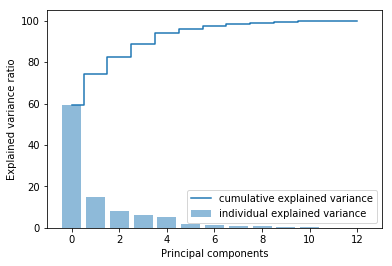

In [51]:
plt.figure(figsize=(6, 4))
plt.bar(range(13), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(13), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
#Together, the first two principal components contain 95.8% of the information.

In [52]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(13,1),
                      eig_pairs[1][1].reshape(13,1),
                      eig_pairs[2][1].reshape(13,1),
                      eig_pairs[3][1].reshape(13,1)))
matrix_w #a 13x4 projection matrix with the concatenated top k eigenvectors

array([[ 0.34135804, -0.12100864,  0.02550658, -0.11182315],
       [-0.09496702, -0.5215757 ,  0.23370851, -0.04361501],
       [ 0.32956659,  0.17015087, -0.1366166 , -0.07992297],
       [ 0.35208846,  0.0648868 , -0.10429655, -0.06031806],
       [ 0.31140355,  0.02973509, -0.16165168, -0.02885002],
       [ 0.25931728, -0.15809517,  0.32929857,  0.51514277],
       [ 0.34752698,  0.11911745, -0.084941  , -0.04387094],
       [ 0.09378982, -0.56345905, -0.45630914,  0.04312346],
       [ 0.28681507,  0.00373138, -0.48453009,  0.05537037],
       [ 0.32698052,  0.09972596,  0.21275901, -0.12998697],
       [ 0.14599792, -0.55315463,  0.12929996, -0.30180708],
       [ 0.25977808,  0.0638423 ,  0.45837297, -0.47184777],
       [ 0.26477762, -0.05084958,  0.24150775,  0.6098265 ]])

In [53]:
# dot product of the scaled data & matrix_W
datamat = scaled_data.dot(matrix_w)

In [61]:
datamat.shape

(1188, 4)

Text(0,0.5,'Principal Component 2')

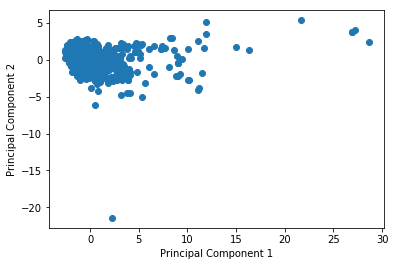

In [54]:
plt.figure(figsize=(6, 4))
plt.scatter(datamat[:,0],datamat[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Text(0.5,1,'Scree Plot')

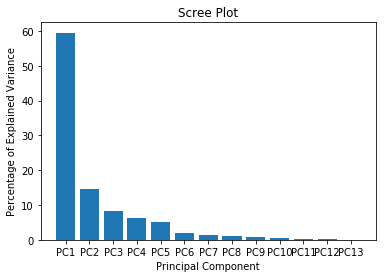

In [55]:
pca = PCA().fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1) #percent variation
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')

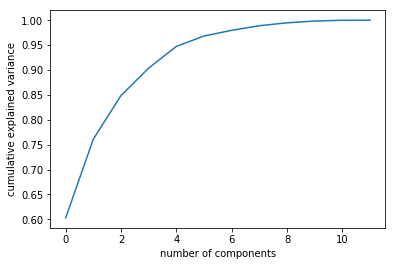

In [21]:
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [56]:
pca_df = pd.DataFrame(pca_data,index =dff.ChemSpider_ID ,columns=labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
ChemSpider_ID,,,,,,,,,,,,,
103,-0.953397,-2.536109,0.224099,-0.050415,0.550496,0.833400,0.449972,-0.384215,-0.073659,-0.049285,-0.135843,0.072941,-0.008476
134,-1.547240,-2.043061,0.296685,-0.202628,0.036003,0.198509,0.226481,0.070375,0.033754,-0.114398,-0.108670,0.017735,-0.003120
140,2.225238,-0.857648,0.870477,-1.463760,1.283511,-0.218774,0.188872,-0.279281,0.124134,-0.237456,-0.173319,-0.107955,-0.011558
185,-1.235747,-0.915739,1.444958,-0.122399,1.127966,-0.451173,-0.059026,0.341851,0.057997,0.185097,-0.050699,-0.021716,0.004063
235,-2.339842,-0.713916,0.063829,-0.190876,-0.059457,0.181440,0.156905,0.248407,0.017873,0.105009,-0.039472,0.012680,-0.001321
292,-0.751197,-1.080817,0.494715,0.099445,-0.300735,0.396390,0.299485,-0.242392,-0.197592,0.033350,0.027596,-0.006137,-0.006144
299,-2.069209,-2.372465,0.457399,-0.381429,0.838290,0.133761,-0.066245,0.141324,0.613433,0.037862,0.118783,-0.036847,0.000680
431,-1.930039,-0.391064,0.133998,-0.092025,-0.759941,0.031047,0.126383,0.190972,-0.042888,0.040981,0.122715,-0.040352,-0.000539
566,-1.326924,-2.244630,0.705887,-0.249842,0.266864,-0.219805,0.113304,0.121191,0.015497,-0.056163,-0.072502,-0.035418,-0.002273


In [64]:
pcadf_dict = {}
for i in range(12):
    pcadf_dict[pca_df.columns[i]] = [pca_df[pca_df.columns[i]],dff.is_NP]
pcadf_dict

{'PC1': [ChemSpider_ID
  103        -0.953397
  134        -1.547240
  140         2.225238
  185        -1.235747
  235        -2.339842
  292        -0.751197
  299        -2.069209
  431        -1.930039
  566        -1.326924
  659        -2.387945
  661        -1.580862
  733        -1.787318
  764        -2.034110
  815        -1.355717
  911        -1.786023
  913        -1.882397
  917        -2.044392
  937        -2.424267
  979        -1.668125
  989        -1.310956
  1017       -1.618079
  1020       -2.375268
  1032       -1.650016
  1042       -1.909635
  1085       -1.767996
  1141       -1.692213
  1143       -1.794555
  1169       -2.174122
  1262       -1.673564
  1556       -1.772390
                ...   
  35013015    2.844065
  36764951    0.195185
  38772329   -0.211099
  38772333    0.555462
  52563936    4.104158
  57269045    3.283621
  57269055    8.614249
  57620495   -1.056335
  61709079    2.524226
  61709081    2.500733
  61709082    2.375507
  61709083 

In [70]:
pcadf_dict['PC1'][1]

0       non-NP
1           NP
2           NP
3           NP
4           NP
5           NP
6           NP
7       non-NP
8           NP
9           NP
10          NP
11          NP
12          NP
13          NP
14          NP
15          NP
16          NP
17          NP
18          NP
19          NP
20      non-NP
21          NP
22          NP
23          NP
24      non-NP
25          NP
26          NP
27          NP
28          NP
29      non-NP
         ...  
1158    non-NP
1159    non-NP
1160    non-NP
1161    non-NP
1162    non-NP
1163    non-NP
1164    non-NP
1165    non-NP
1166        NP
1167        NP
1168        NP
1169        NP
1170        NP
1171        NP
1172        NP
1173        NP
1174        NP
1175        NP
1176        NP
1177        NP
1178        NP
1179        NP
1180        NP
1181        NP
1182        NP
1183        NP
1184    non-NP
1185    non-NP
1186    non-NP
1187    non-NP
Name: is_NP, Length: 1188, dtype: object

In [56]:
for i in pca_df.columns:
    print(sum(pca_df[i]))

-2.56905607898e-13
2.38697950294e-14
1.11022302463e-14
1.54876111935e-14
-1.82631687551e-14
6.55031584529e-15
5.23470156111e-14
-2.86437540353e-14
-1.47659662275e-14
7.66470220626e-14
-4.93494134446e-14
9.19056497573e-15


In [41]:
pca_df.mean() #mean of each column

PC1    -5.326828e-16
PC2     4.784800e-17
PC3     1.356238e-16
PC4    -3.219460e-17
PC5     3.317586e-17
PC6    -4.896943e-17
PC7    -3.085121e-17
PC8    -3.600281e-17
PC9     2.696122e-17
PC10    4.763773e-17
PC11   -4.435519e-17
PC12    4.611327e-18
dtype: float64

In [ ]:
colours = [ 'blue' if x == 'NP' else 'purple' for x in pcadf_dict['PC1'][1]]

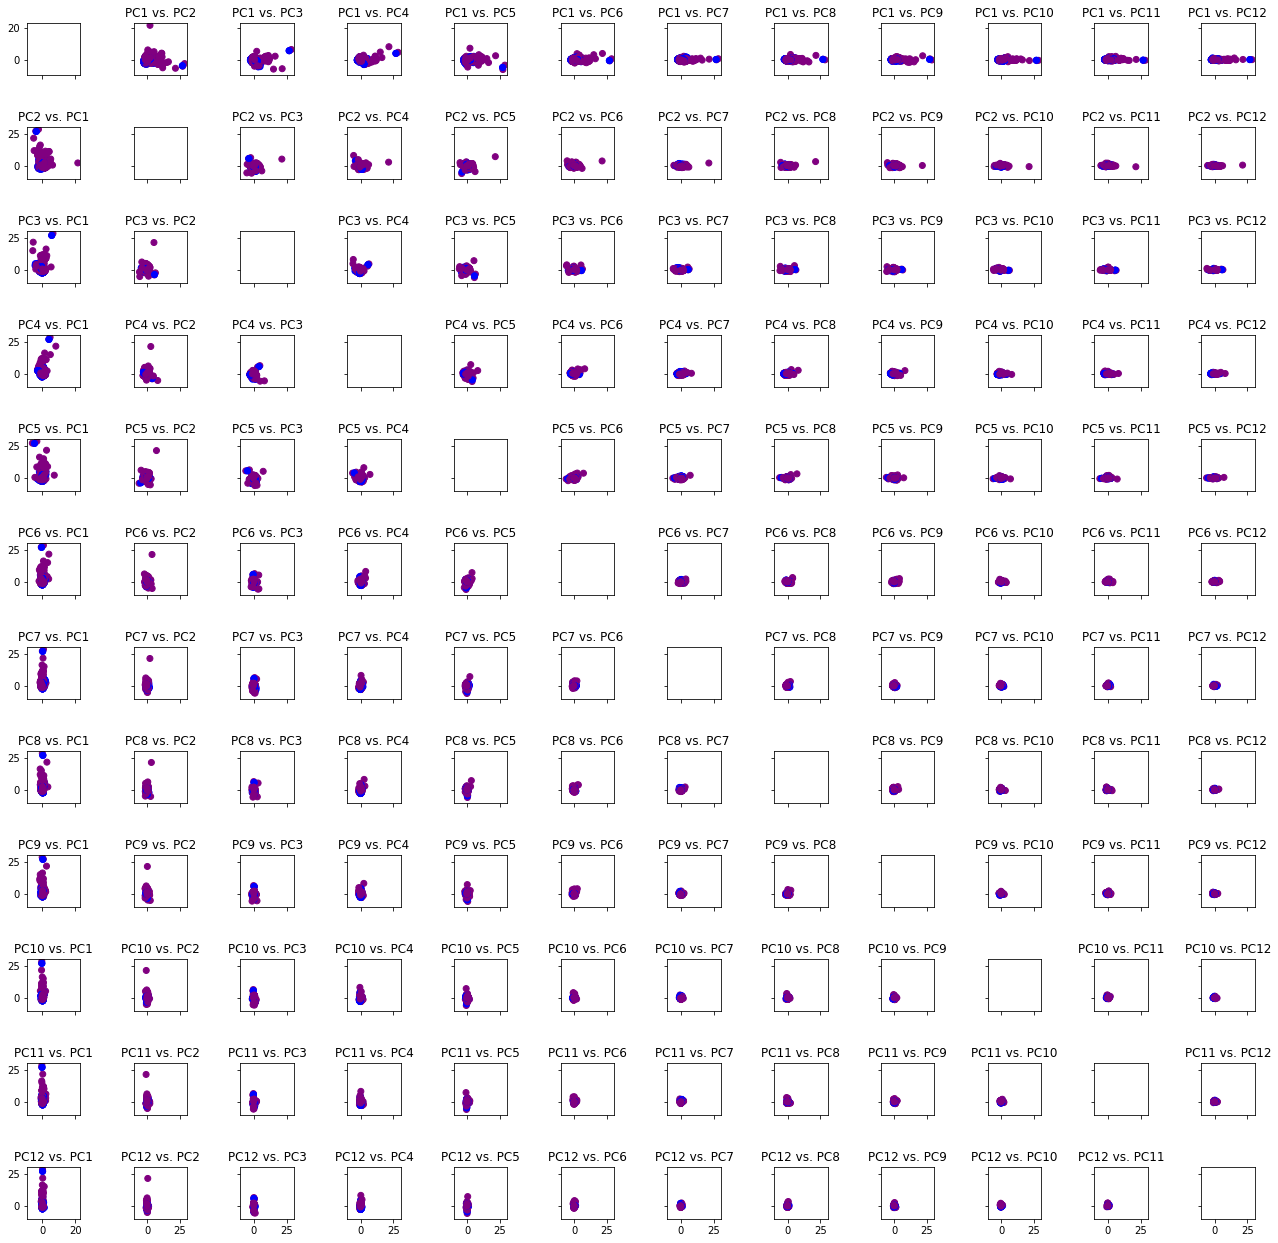

In [84]:
fig, ax = plt.subplots(12,12, sharex='col', sharey='row',figsize=(22,22))
fig.subplots_adjust(wspace=1,hspace=1)
for i in range(12):
    for j in range(12):
        if i == j:
            pass
        else:
            ax[i,j].scatter(pcadf_dict['PC{}'.format(i+1)][0], 
                            pcadf_dict['PC{}'.format(j+1)][0],
                            c=colours)#,edgecolors='black')
            ax[i,j].set_title('PC{} vs. PC{}'.format(i+1,j+1))
#        plt.xlabel('PC1 - {0}%'.format(per_var[0]))
#        plt.ylabel('PC2 - {0}%'.format(per_var[1]))

Text(0,0.5,'Principal Component 2')

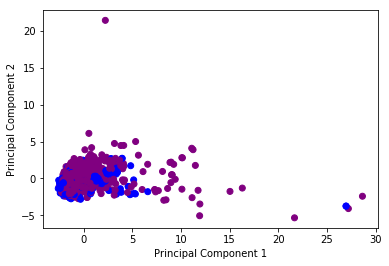

In [82]:
plt.figure(figsize=(6, 4))
plt.scatter(pcadf_dict['PC1'][0],pcadf_dict['PC2'][0],c=colours)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [ ]:
'''remove water from dictionary'''
for s in outerDict.keys():
    q = outerDict[s]['Common Name']
    m = re.search('water',q,re.IGNORECASE)
    if m:
        print(s)
        outerDict.pop(s) #or del outerDict['937]